In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import os

`pd.read_csv` 
> sep=`<no_default>`, names=`<no_default>`  
> sep='\t' -> 구분자를 탭으로 하여

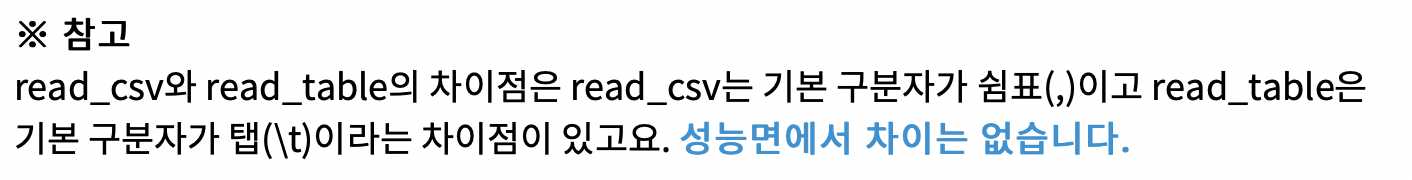
https://zephyrus1111.tistory.com/38

In [2]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')

print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 208906


,eng,fra,cc
29793,Everybody's in bed.,Tout le monde est au lit.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
5709,Let Tom know.,Informez Tom.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
110644,There are no further details.,Il n'y a pas d'autres détails.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
138044,Let me know where you're staying.,Faites-moi savoir où vous restez.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
8146,It has a leak.,Il a une fuite.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [6]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, sep='\t')

,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
0,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,En route !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
5,Run!,Cours !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
6,Run!,Courez !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
7,Run!,Prenez vos jambes à vos cous !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
8,Run!,File !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
9,Run!,Filez !,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


`lines.sample`  
(
    n=None,
    frac: 'float | None' = None,
    replace: 'bool_t' = False,
    weights=None,
    __random_state=None__,
    axis: 'Axis | None' = None,
    ignore_index: 'bool_t' = False,
)  
-> 'FrameOrSeries'

In [13]:
lines.sample(5)

,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
177586,He was sentenced to death by firing squad.,Il a été condamné à mort par fusillade.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
173397,Why haven't you eaten the food I cooked?,Pourquoi n'as-tu pas mangé ce que j'ai cuisiné ?,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
205178,I hope that I gave you enough money to buy eve...,J'espère que je t'ai donné assez d'argent pour...,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
84566,I'm very sad to hear that.,Je suis très triste d'entendre cela.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
58055,He is fluent in French.,Il parle couramment le français.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [19]:
lines.info()
# 208,906

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208906 entries, 0 to 208905
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   eng     208906 non-null  object
 1   fra     208906 non-null  object
 2   cc      208906 non-null  object
dtypes: object(3)
memory usage: 4.8+ MB


In [18]:
lines.isnull().sum()

eng    0
fra    0
cc     0
dtype: int64

In [20]:
lines.describe()

,eng,fra,cc
count,208906,208906,208906
unique,148106,192161,208906
top,I can't tell you how happy I am that you've co...,En route !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
freq,29,14,1


In [3]:
lines = lines[['eng', 'fra']][:50000] # 5만개 샘플 사용

In [23]:
lines.sample(5)

,eng,fra
1316,Keep them.,Gardez-les.
9757,You're polite.,Tu es poli.
48084,We have to do better.,Nous devons mieux faire.
3242,I like that.,Ça me plaît.
10881,I love secrets.,J'adore les secrets.


`seq2seq` 동작을 위해서 디코더의 입력과 예측에는  
`시작 토큰 <sos>와 종료 토큰 <eos>`가 필요합니다.  
이번에는 각각 \t와 \n을 사용하겠습니다.  
두 토큰을 추가해줍니다.  

In [4]:
# 시작 토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x : '\t '+ x + ' \n')

print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 50000


,eng,fra
39581,That's a good point.,\t C'est une bonne remarque. \n
6744,Are you a cop?,\t Êtes-vous flic ? \n
20532,Listen carefully.,\t Écoutez attentivement. \n
28548,Why am I so tired?,\t Pourquoi suis-je si fatiguée ? \n
47185,They took a big risk.,\t Elles prirent un gros risque. \n


이제 단어장(vocabulary)을 만들고,  
각 단어에 부여된 고유한 정수로 text sequence를 --> 정수 sequence로 변환하는 정수 Encoding 과정을 거치겠습니다.  
이때 Eng와 French는 사용하는 언어가 다르므로 단어장을 별도로 만들어줍니다.  
그리고 정상적으로 정수 시퀀스로 변환되었는지 3개의 행을 출력합니다.  

In [5]:
eng_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 

In [6]:
# Updates internal vocabulary based on a list of texts.
eng_tokenizer.fit_on_texts(lines.eng)
# 50000개의 행을 가진 eng의 각 행에 토큰화를 수행

# Transforms each text in texts to a sequence of integers.
input_text = eng_tokenizer.texts_to_sequences(lines.eng)
# 단어를 숫자값 인덱스로 변환하여 저장

In [29]:
input_text[:3] # 50,000
# # 'g': 19, '.': 8,

[[19, 4, 8], [19, 4, 8], [19, 4, 8]]

In [38]:
lines.fra

0                                   \t Va ! \n
1                                \t Marche. \n
2                             \t En route ! \n
3                                \t Bouge ! \n
4                                \t Salut ! \n
                         ...                  
49995     \t Devez-vous partir maintenant ? \n
49996       \t Dois-tu y aller maintenant ? \n
49997    \t Devez-vous y aller maintenant ? \n
49998         \t Est-ce que tu as du thon ? \n
49999                    \t As-tu du thon ? \n
Name: fra, Length: 50000, dtype: object

`char_level=False`  
if True, every character will be treated as a token

In [7]:
fra_tokenizer = Tokenizer(char_level=True)   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]
# '\t': 10, '\n': 11,

[[10, 1, 19, 5, 1, 31, 1, 11],
 [10, 1, 15, 5, 12, 16, 29, 2, 14, 1, 11],
 [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]]

In [33]:
eng_tokenizer.word_index

{' ': 1,
 'e': 2,
 't': 3,
 'o': 4,
 'i': 5,
 'a': 6,
 's': 7,
 '.': 8,
 'r': 9,
 'n': 10,
 'h': 11,
 'l': 12,
 'd': 13,
 'y': 14,
 'u': 15,
 'm': 16,
 'w': 17,
 "'": 18,
 'g': 19,
 'c': 20,
 'p': 21,
 'k': 22,
 'b': 23,
 'f': 24,
 'v': 25,
 '?': 26,
 '!': 27,
 'j': 28,
 'x': 29,
 ',': 30,
 'z': 31,
 'q': 32,
 '-': 33,
 '0': 34,
 '3': 35,
 '1': 36,
 '2': 37,
 '9': 38,
 ':': 39,
 '"': 40,
 '5': 41,
 '7': 42,
 '8': 43,
 '6': 44,
 '$': 45,
 '4': 46,
 '%': 47,
 'é': 48,
 '’': 49,
 '&': 50,
 '/': 51,
 '€': 52}

In [35]:
fra_tokenizer.word_index

{' ': 1,
 'e': 2,
 's': 3,
 't': 4,
 'a': 5,
 'i': 6,
 'n': 7,
 'u': 8,
 'o': 9,
 '\t': 10,
 '\n': 11,
 'r': 12,
 'l': 13,
 '.': 14,
 'm': 15,
 'c': 16,
 'p': 17,
 'd': 18,
 'v': 19,
 'é': 20,
 "'": 21,
 'j': 22,
 'f': 23,
 '-': 24,
 '?': 25,
 'b': 26,
 'q': 27,
 'g': 28,
 'h': 29,
 'z': 30,
 '!': 31,
 'x': 32,
 'ê': 33,
 'à': 34,
 'y': 35,
 'è': 36,
 'ç': 37,
 '\u202f': 38,
 '\xa0': 39,
 ',': 40,
 'î': 41,
 'ô': 42,
 'ù': 43,
 '’': 44,
 'û': 45,
 'â': 46,
 'œ': 47,
 'k': 48,
 'ï': 49,
 'w': 50,
 '0': 51,
 '\u2009': 52,
 '1': 53,
 '3': 54,
 '«': 55,
 '»': 56,
 'ë': 57,
 '9': 58,
 '2': 59,
 '5': 60,
 '7': 61,
 '8': 62,
 ':': 63,
 '6': 64,
 '4': 65,
 '%': 66,
 '"': 67,
 '&': 68,
 '(': 69,
 ')': 70,
 '$': 71,
 '‘': 72}

In [8]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
# 0번 토큰을 고려하여 +1을 하고 저장

영어 단어장의 크기 : 53
프랑스어 단어장의 크기 : 73


이제 영어 데이터와 프랑스어 데이터의 최대 길이를 각각 구해보겠습니다.  
이는 패딩(`<pad>`)을 위함입니다.  
모델에 입력될 Eng, French의 Sequence의 길이가 일정해야 하므로,  
최대 길이로 맞추고 남는 시퀀스 뒷부분을 패딩으로 채우게 됩니다.  
-> padding="post"

1. input_text  
> texts_to_sequences  
> eng -> integer  

2. target_text  
> texts_to_sequences  
> French -> integer  

In [9]:
max_eng_seq_len = max([len(line) for line in input_text])
# len([19, 4, 8])
max_fra_seq_len = max([len(line) for line in target_text])
# len([10, 1, 19, 5, 1, 31, 1, 11])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 22
프랑스어 시퀀스의 최대 길이 76


In [10]:
print('전체 샘플의 수 :',len(lines))
print("-" * 10)
# len(eng_tokenizer.word_index) + 1 -> # 'i': 5,
print('영어 단어장의 크기 :', eng_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print("-" * 10)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 30000
----------
영어 단어장의 크기 : 51
영어 시퀀스의 최대 길이 19
----------
프랑스어 단어장의 크기 : 73
프랑스어 시퀀스의 최대 길이 61


Encoder의 input으로 사용되는 Eng 시퀀스와 달리,  
French 시퀀스는 2가지 버전으로 나누어 준비  
1st는 Decoder의 output과 비교해야 할 정답 데이터로 사용해야 할 원래 목적에 따른 것  
그리고 다른 하나는 이전 스텝에서 언급했던 Teacher forcing을 위해  
Decoder의 input으로 사용하기 위한 것  

같은 문장을 굳이 2가지 버전으로 나누는 이유는,  
Decoder의 input으로 사용할 시퀀스는 `<eos>` token이 필요가 없고,  
Decoder의 output과 비교할 시퀀스는 `<sos>`가 필요가 없기 때문  

가령, Eng로 'I am a person'이라는 문장을  
Frnech 'Je suis une personne'로 번역하는 번역기를 만든다고 해야  
train 과정에서 Decoder는 '`<sos>` Je suis une personne'를  
input받아서 'Je suis une personne `<eos>`'를 예측하도록 train되므로,  
이런 방식으로 생성된 두가지 버전의 시퀀스를 준비해야 합니다.  

In [45]:
eos_token, sos_token

('\n', '\t')

In [49]:
fra_tokenizer.word_index[eos_token],\
fra_tokenizer.word_index[sos_token]

(11, 10)

for line in target_text  
for char in line  
if char != fra_tokenizer.word_index[eos_token]  
char  

In [10]:
encoder_input = input_text

# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 

# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [55]:
# [[10, 1, 19, 5, 1, 31, 1],
len(decoder_input), len(decoder_target)
# [[1, 19, 5, 1, 31, 1, 11],

(50000, 50000)

decoder_input의 경우에는 `숫자 11(<eos> 토큰)`가 제거  
decoder_target의 경우에는 `숫자 10(<sos> 토큰)`이 제거  

---
이제 Padding을 진행합니다.  
Padding을 진행하면 모든 샘플들의 길이가 정해준 길이로 동일하게 변환됩니다.  
여기서는 아까 저장해두었던 가장 긴 샘플의 길이인  
max_eng_seq_len, max_fra_seq_len를 각각 사용하였습니다.

---
Eng 데이터의 모든 샘플들은 max_eng_seq_len의 길이를 가지고,  
French의 모든 샘플들은 max_fra_seq_len의 길이가 되겠죠?  

In [11]:
encoder_input = pad_sequences(encoder_input, 
                              maxlen = max_eng_seq_len, padding='post')

decoder_input = pad_sequences(decoder_input, 
                              maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, 
                               maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 22)
프랑스어 입력데이터의 크기(shape) : (50000, 76)
프랑스어 출력데이터의 크기(shape) : (50000, 76)


모든 샘플들의 길이가 동일하게 변환된 것을 알 수 있습니다.  
모든 샘플들의 길이가 동일하게 변환되는 과정에서 
정해준 길이보다 짧은 데이터들은 뒤에 `0(<pad>)`으로 채워집니다.  
Encoder의 샘플 하나만 출력해볼까요?

In [13]:
print(encoder_input[0]) # 22

[19  4  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


앞서 [19, 3, 8]이라는 3개의 단어만 있단 sample이 뒤에 0이 채워지면서  
`max_eng_seq_len의 값인 23의 길이`를 가지게 되었습니다.  
이제 각 정수에 대해서 Vector 방법으로 One-hot Encoding을 선택합니다.  

In [12]:
# Converts a class vector (integers) to binary class matrix.
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 22, 53)
프랑스어 입력데이터의 크기(shape) : (50000, 76, 73)
프랑스어 출력데이터의 크기(shape) : (50000, 76, 73)


In [63]:
encoder_input[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

One-hot Encoding을 하고나서의 data의 size는 `(샘플의 수 × 샘플의 길이 × 단어장의 크기)`  
One-hot Encoding은 각 정수를 단어장의 크기를 가지는 One-hot Vector로 Encoding하는 과정이기 때문입니다.  

마지막으로, train과정의 validation을 위해 위에서  
생성한 데이터 50000건 중 3000건만 Validate data로 삼고,  
나머지를 train data로 삼겠습니다.  

In [13]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (50000, 22, 53)
프랑스어 학습 입력데이터의 크기(shape) : (50000, 76, 73)
프랑스어 학습 출력데이터의 크기(shape) : (50000, 76, 73)


In [65]:
encoder_input_train[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [66]:
encoder_input_test[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# 7-8. 번역기 만들기 (2) 모델 훈련하기

In [14]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

Encoder의 마지막 hidden state를  
Decoder의 1st hidden state로 사용한다고 했었지요?  

일반적인 RNN의 경우에는 그것이 맞지만,  
기본 RNN보다 좀 더 복잡한 LSTM의 경우에는  
hidden state뿐만 아니라,  
cell sate라는 것이 존재  

---
Encoder LSTM 셀의 마지막 time step의 hidden state와 cell state -->  
Decoder LSTM의 1st hidden state와 cell state로 전달해주어야 합니다.  

In [15]:
# 입력 텐서 생성.
encoder_inputs = Input(shape=(None, eng_vocab_size)) # 53

In [71]:
encoder_inputs

<KerasTensor: shape=(None, None, 53) dtype=float32 (created by layer 'input_1')>

`return_state` -> Boolean(`False`)   

Whether to return __the last state__ in addition to __the output__  

In [16]:
# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(units = 256, return_state = True)
# return_sequences=False,
#     return_state=False,

In [73]:
encoder_lstm

In [80]:
encoder_outputs, state_h, state_c

(<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>)

In [17]:
# 디코더로 전달할 hidden state, cell state를 리턴. 
# encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

1st 줄  
우선 LSTM의 입력 텐서를 정의해줍니다. 입력 문장을 저장하게 될 변수 텐서입니다.  

2nd 줄  
256의 hidden_size를 가지는 LSTM 셀을 만들어줍니다.  
LSTM의 수용력(capacity)를 의미합니다.  
return_state = True를 해서 hidden state와 cell state를 리턴  

3rd 줄  
입력 텐서를 사용하여 마지막 time step의 hidden state와 cell state를 결과로  

4th 줄  
마지막 time step의 hidden state와 cell state를 encoder_states라는 하나의 변수에 저장해뒀습니다. 이를 Decoder에 전달하면 되겠네요.  

In [18]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None, fra_vocab_size))
# hidden size가 256인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(units = 256, return_sequences = True, 
                    return_state=True)

In [84]:
fra_vocab_size, decoder_inputs, encoder_states

(73,
 <KerasTensor: shape=(None, None, 73) dtype=float32 (created by layer 'input_2')>,
 [<KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>,
  <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'lstm')>])

`initial_state`  
List of initial state tensors to be passed to the first call of the cell  
(optional, defaults to `None` which causes creation of zero-filled initial state tensors).  

In [19]:
# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _= decoder_lstm(decoder_inputs, 
                                    initial_state = encoder_states)

In [87]:
decoder_outputs

<KerasTensor: shape=(None, None, 256) dtype=float32 (created by layer 'lstm_1')>

세번째 줄을 보면 Decoder의 인자로 initial_state가 추가  
LSTM 셀의 초기 상태를 정의해줄 수 있는 인자  
여기서는 이전에 저장한 Encoder의 마지막 time step의 hidden state와 cell state를 사용  
Decoder의 Output Layer을 설계  

In [89]:
fra_vocab_size, decoder_outputs

(73,
 <KerasTensor: shape=(None, None, 256) dtype=float32 (created by layer 'lstm_1')>)

In [20]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [100]:
decoder_softmax_layer,\
decoder_outputs

(<keras.layers.core.Dense at 0x7fde3c7f8d30>,
 <KerasTensor: shape=(None, None, 73) dtype=float32 (created by layer 'dense_1')>)

매 time step마다의 Multiple Class classification 문제이므로  
French 단어장으로부터 한 가지 문자만 선택하도록 합니다.  
Dense의 인자로 French 단어장의 크기를 기재하고,  
Activation Function로 Softmax 함수를 사용,  
Final은 Encoder와 Decoder를 연결해서 하나의 모델로 만들어줍니다.  
Model의 Input과 Output의 정의를 유심히 살펴 주세요.  

In [21]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer="rmsprop", 
              loss="categorical_crossentropy")

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 53)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 317440      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 lstm[0][1]                   

In [22]:
model.fit(x=[encoder_input_train, decoder_input_train], 
          y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], 
                             decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
368/368 [==============================] - 12s 21ms/step - loss: 0.8905 - val_loss: 0.7707
Epoch 2/50
368/368 [==============================] - 7s 19ms/step - loss: 0.5448 - val_loss: 0.6098
Epoch 3/50
368/368 [==============================] - 7s 19ms/step - loss: 0.4536 - val_loss: 0.5143
Epoch 4/50
368/368 [==============================] - 7s 20ms/step - loss: 0.3953 - val_loss: 0.4671
Epoch 5/50
368/368 [==============================] - 7s 20ms/step - loss: 0.3580 - val_loss: 0.4303
Epoch 6/50
368/368 [==============================] - 7s 20ms/step - loss: 0.3318 - val_loss: 0.4152
Epoch 7/50
368/368 [==============================] - 7s 20ms/step - loss: 0.3120 - val_loss: 0.3943
Epoch 8/50
368/368 [==============================] - 7s 19ms/step - loss: 0.2960 - val_loss: 0.3774
Epoch 9/50
368/368 [==============================] - 7s 19ms/step - loss: 0.2827 - val_loss: 0.3720
Epoch 10/50
368/368 [==============================] - 7s 19ms/step - loss: 0.2715 - val_l

# 7-9. 번역기 만들기 (3) 모델 테스트하기 

`seq2seq`는 훈련할 때와 테스트 단계의 동작이 다릅니다.  
이를 위해서 테스트 단계의 Decoder 모델은 설계를 다시 해줄 필요가 있습니다.  
물론 이전에 학습된 Decoder 모델의 layer 그대로 사용합니다.  
왜 이렇게 번거로운 과정이 생기는 것일까요?  

Text Generator 모델을 만들어 보신 분이라면 알 수 있습니다.  
훈련시에는 학습해야 할 타겟 문장을  
Decoder 모델의 입력, 출력 시퀀스로 넣어 주고, Decoder 모델이 타겟 문장을 한꺼번에 출력하게 할 수 있습니다.  
그러나 test 단계에서는 그럴 수가 없습니다.  
하나의 문장을 만들어 내기 위해 루프를 돌며 단어를 하나씩 차례차례 예측하면서,  
predicted 단어가 다음 입력으로 재사용되는 과정이 반복되기 때문입니다.  

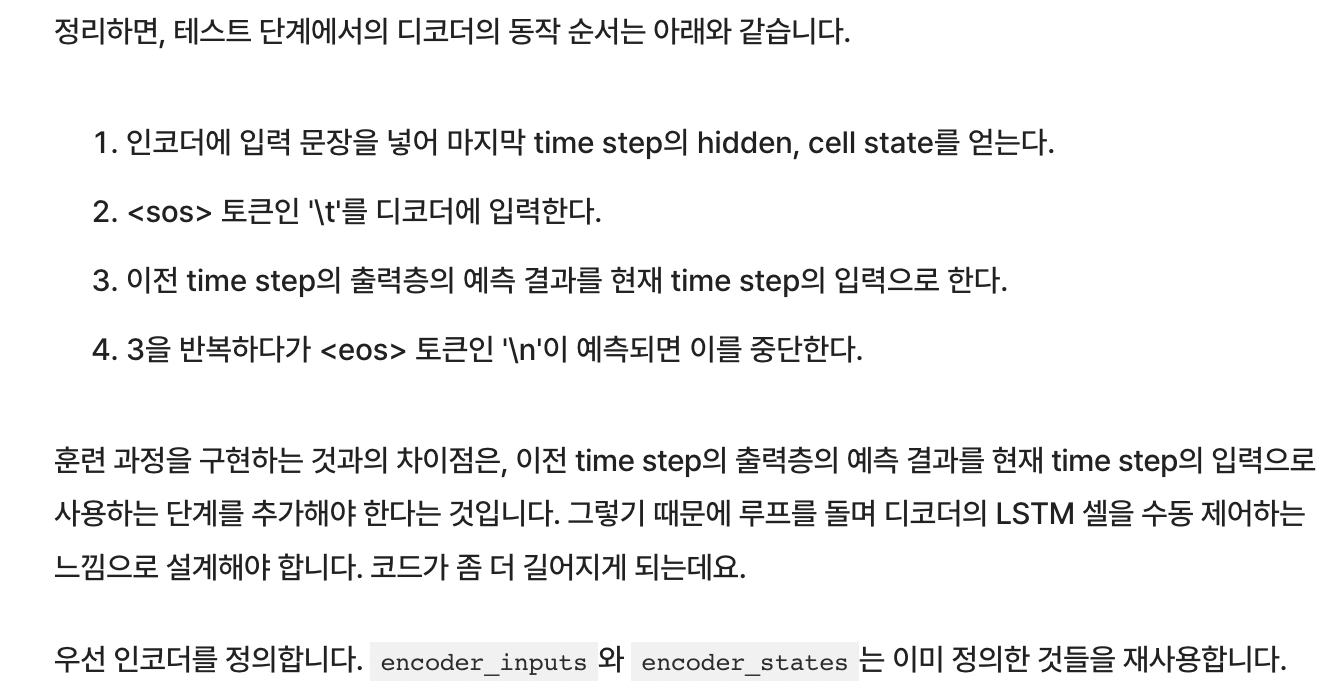

In [23]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 53)]        0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 317440    
Total params: 317,440
Trainable params: 317,440
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(256,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states = [state_h, state_c]

훈련 과정에서의 디코더보다 코드가 좀 더 길어졌죠?  
이전 time step의 출력 결과를 현재 time step의 입력으로 사용하기 위해서  
Decoder LSTM 셀의 동작을 좀 더 세분화해서 구현했습니다.  
동작 자체는 이후에 구현할 함수 decode_sequence()에서 좀 더 자세히 다루겠습니다.  

Decoder의 출력층을 재설계해줍니다.

In [25]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 input_3[0][0]              

In [26]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

단어 -> 정수로, 정수 -> 단어로 바꾸는 사전(dictionary)을 준비해 둡니다.  
테스트 결과를 해석하기 위해선 다시 사전이 필요하겠죠?  
우리는 이전 스텝에서 문장 -> 숫자 인덱스로 바꾸는  
Tokenizer를 만들면서 자동으로 만들어진 사전을 이미 가지고 있습니다.

In [107]:
eng2idx

{' ': 1,
 'e': 2,
 't': 3,
 'o': 4,
 'i': 5,
 'a': 6,
 's': 7,
 '.': 8,
 'r': 9,
 'n': 10,
 'h': 11,
 'l': 12,
 'd': 13,
 'y': 14,
 'u': 15,
 'm': 16,
 'w': 17,
 "'": 18,
 'g': 19,
 'c': 20,
 'p': 21,
 'k': 22,
 'b': 23,
 'f': 24,
 'v': 25,
 '?': 26,
 '!': 27,
 'j': 28,
 'x': 29,
 ',': 30,
 'z': 31,
 'q': 32,
 '-': 33,
 '0': 34,
 '3': 35,
 '1': 36,
 '2': 37,
 '9': 38,
 ':': 39,
 '"': 40,
 '5': 41,
 '7': 42,
 '8': 43,
 '6': 44,
 '$': 45,
 '4': 46,
 '%': 47,
 'é': 48,
 '’': 49,
 '&': 50,
 '/': 51,
 '€': 52}

In [108]:
fra2idx

{' ': 1,
 'e': 2,
 's': 3,
 't': 4,
 'a': 5,
 'i': 6,
 'n': 7,
 'u': 8,
 'o': 9,
 '\t': 10,
 '\n': 11,
 'r': 12,
 'l': 13,
 '.': 14,
 'm': 15,
 'c': 16,
 'p': 17,
 'd': 18,
 'v': 19,
 'é': 20,
 "'": 21,
 'j': 22,
 'f': 23,
 '-': 24,
 '?': 25,
 'b': 26,
 'q': 27,
 'g': 28,
 'h': 29,
 'z': 30,
 '!': 31,
 'x': 32,
 'ê': 33,
 'à': 34,
 'y': 35,
 'è': 36,
 'ç': 37,
 '\u202f': 38,
 '\xa0': 39,
 ',': 40,
 'î': 41,
 'ô': 42,
 'ù': 43,
 '’': 44,
 'û': 45,
 'â': 46,
 'œ': 47,
 'k': 48,
 'ï': 49,
 'w': 50,
 '0': 51,
 '\u2009': 52,
 '1': 53,
 '3': 54,
 '«': 55,
 '»': 56,
 'ë': 57,
 '9': 58,
 '2': 59,
 '5': 60,
 '7': 61,
 '8': 62,
 ':': 63,
 '6': 64,
 '4': 65,
 '%': 66,
 '"': 67,
 '&': 68,
 '(': 69,
 ')': 70,
 '$': 71,
 '‘': 72}

In [109]:
idx2eng

{1: ' ',
 2: 'e',
 3: 't',
 4: 'o',
 5: 'i',
 6: 'a',
 7: 's',
 8: '.',
 9: 'r',
 10: 'n',
 11: 'h',
 12: 'l',
 13: 'd',
 14: 'y',
 15: 'u',
 16: 'm',
 17: 'w',
 18: "'",
 19: 'g',
 20: 'c',
 21: 'p',
 22: 'k',
 23: 'b',
 24: 'f',
 25: 'v',
 26: '?',
 27: '!',
 28: 'j',
 29: 'x',
 30: ',',
 31: 'z',
 32: 'q',
 33: '-',
 34: '0',
 35: '3',
 36: '1',
 37: '2',
 38: '9',
 39: ':',
 40: '"',
 41: '5',
 42: '7',
 43: '8',
 44: '6',
 45: '$',
 46: '4',
 47: '%',
 48: 'é',
 49: '’',
 50: '&',
 51: '/',
 52: '€'}

In [110]:
idx2fra

{1: ' ',
 2: 'e',
 3: 's',
 4: 't',
 5: 'a',
 6: 'i',
 7: 'n',
 8: 'u',
 9: 'o',
 10: '\t',
 11: '\n',
 12: 'r',
 13: 'l',
 14: '.',
 15: 'm',
 16: 'c',
 17: 'p',
 18: 'd',
 19: 'v',
 20: 'é',
 21: "'",
 22: 'j',
 23: 'f',
 24: '-',
 25: '?',
 26: 'b',
 27: 'q',
 28: 'g',
 29: 'h',
 30: 'z',
 31: '!',
 32: 'x',
 33: 'ê',
 34: 'à',
 35: 'y',
 36: 'è',
 37: 'ç',
 38: '\u202f',
 39: '\xa0',
 40: ',',
 41: 'î',
 42: 'ô',
 43: 'ù',
 44: '’',
 45: 'û',
 46: 'â',
 47: 'œ',
 48: 'k',
 49: 'ï',
 50: 'w',
 51: '0',
 52: '\u2009',
 53: '1',
 54: '3',
 55: '«',
 56: '»',
 57: 'ë',
 58: '9',
 59: '2',
 60: '5',
 61: '7',
 62: '8',
 63: ':',
 64: '6',
 65: '4',
 66: '%',
 67: '"',
 68: '&',
 69: '(',
 70: ')',
 71: '$',
 72: '‘'}

이제 예측 과정을 위한 함수 decode_sequence()를 구현합니다.  
decode_sequence()의 입력으로 들어가는 것은 번역하고자 하는 문장의 정수 시퀀스입니다.   
decode_sequence() 내부에는  
인코더를 구현한 encoder_model이 있어서 이 모델에 번역하고자 하는 문장의 정수 시퀀스인 'input_seq'를 입력하면,   
encoder_model은 마지막 시점의 hidden state를 리턴합니다

In [116]:
states_value = encoder_model.predict(input_seq)

In [119]:
len(states_value)

2

이 hidden state는 Decoder의 1st 시점의 hidden state가 되고,  
Decoder 이제 번역 문장을 완성하기 위한 예측 과정을 진행합니다.  
Decoder 예측 과정에서는 이전 시점에서 예측한 단어를 Decoder의 현재 시점의 입력으로 넣어주는 작업을 진행합니다.  
그리고 이 작업은 종료를 의미하는 종료 토큰을 만나거나,  
주어진 최대 길이를 넘을 때까지 반복합니다.  

In [27]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, fra_vocab_size))
    target_seq[0, 0, fra2idx['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, fra_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [28]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) 
    # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) 
    # '\n'을 빼고 출력

-----------------------------------
입력 문장: Go.
정답 문장:  Bouge ! 
번역기가 번역한 문장:  va te faire de marie ! 
-----------------------------------
입력 문장: Hello!
정답 문장:  Bonjour ! 
번역기가 번역한 문장:  salut ! 
-----------------------------------
입력 문장: Got it!
정답 문장:  Compris ! 
번역기가 번역한 문장:  à ce que je dis ! 
-----------------------------------
입력 문장: Goodbye.
정답 문장:  Ciao. 
번역기가 번역한 문장:  accorrez ! 
-----------------------------------
입력 문장: He is old.
정답 문장:  Il est vieux. 
번역기가 번역한 문장:  il est tout à fait amusant. 


In [31]:
decode_sequence(encoder_input[3:4])

' va ! \n'

In [32]:
import numpy as np

for seq_index in [3, 50, 100, 1001]:
    input_seq = encoder_input[seq_index : seq_index+1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print("입력 문장 :", lines.eng[seq_index])
    print("정답 문장 :", lines.fra[seq_index][1:len(lines.fra[seq_index]) -1])
    print("번역기가 번약한 문장 :", decoded_sentence[:len(decoded_sentence)-1])

-----------------------------------
입력 문장 : Go.
정답 문장 :  Bouge ! 
번역기가 번약한 문장 :  va ! 
-----------------------------------
입력 문장 : Hello!
정답 문장 :  Bonjour ! 
번역기가 번약한 문장 :  bonjour ! 
-----------------------------------
입력 문장 : Got it!
정답 문장 :  Compris ! 
번역기가 번약한 문장 :  allez-y ! 
-----------------------------------
입력 문장 : He is old.
정답 문장 :  Il est vieux. 
번역기가 번약한 문장 :  il est faible. 


In [132]:
decoder_inputs

<KerasTensor: shape=(None, None, 73) dtype=float32 (created by layer 'input_2')>